In [1]:
from utils import *
from tqdm.notebook import tqdm

In [2]:
class LambdaBuilder:
    
    def __init__(self, lambdas=None, **kwargs):
        if lambdas is None:
            lambdas = get_lambdas(**kwargs)
        self.lambdas = lambdas
        
    def with_members(self, indices):
        self.lambdas = self.lambdas[(self.lambdas["s1"].isin(indices)) & (self.lambdas["s2"].isin(indices))]
        return self
    
    def equals(self):
        self.lambdas = self.lambdas[self.lambdas["s1"] == self.lambdas["s2"]]
        return self
    
    def unequals(self):
        self.lambdas = self.lambdas[self.lambdas["s1"] != self.lambdas["s2"]]
        return self
    
    def unique(self, across_instances=False, one_per_instance=False):
        
        if across_instances:
            seen_indices = set()
            included_instances = set()
            mask = []
            
            for row in self.lambdas.values:
                i, s1, s2, s3, s4 = (row[0], row[1], row[2], row[4], row[5]) if "s3" in self.lambdas else (row[0], row[1], row[2], None, None)
                forbidden = s1 in seen_indices or s2 in seen_indices or s3 in seen_indices or s4 in seen_indices or (one_per_instance and i in included_instances)
                mask.append(forbidden)
                if not forbidden:
                    seen_indices.add(s1)
                    seen_indices.add(s2)
                    if s3 is not None:
                        seen_indices.add(s3)
                        seen_indices.add(s4)
                    included_instances.add(i)
            mask = np.array(mask)
            self.lambdas = self.lambdas[~mask]
        
        else:
            dfs = []
            for i, df_i in self.lambdas.groupby("i"):
                seen_indices = set()
                mask = []
                for s1, s2 in df_i[["s1", "s2"]].values:
                    forbidden = s1 in seen_indices or s2 in seen_indices
                    mask.append(forbidden)
                    if not forbidden:
                        seen_indices.add(s1)
                        seen_indices.add(s2)
                mask = np.array(mask)
                dfs.append(df_i[~mask])
            self.lambdas = pd.concat(dfs)
        return self
    
    def copy(self):
        return LambdaBuilder(self.lambdas)
    
    def reduce(self, reduce_fun):
        self.lambdas = self.lambdas[reduce_fun(self.lambdas)]
        return self
    
    def combine(self, builder, on=None, lambda_filter=None, require_right_is_not_smaller=True, only_one_per_instance=False):
        df_y = builder.lambdas.rename(columns={"s1": "s3", "s2": "s4", "lambda": "lambda2"})
        df = self.lambdas.rename(columns={"lambda": "lambda1"}).merge(df_y, on="i")
        if require_right_is_not_smaller:
            df = df[df["s3"] >= df["s2"]]
        self.lambdas = df
        if lambda_filter is not None:
            self.reduce(lambda_filter)
        return self

# Is $Cov[\lambda_i^{ss},\lambda_i^{ss'}]$ independent of the choice of $s$ and $s'$?

In [17]:
rows = []

for t in [2**i for i in range(2, 8)]:
    print(t)
    covs_t = []
    for seed in tqdm(range(100)):
        base_config = {
            "t": t,
            "random_state_clf": seed
        }
        lambdas = get_lambdas(**base_config)

        lb_base = LambdaBuilder(lambdas)
        
        """
            COV[ss, ss_p]
        """
        
        # for no repeated trees
        lb1 = lb_base.copy().equals()
        lb2 = lb_base.copy().unequals().unique()
        lb1.combine(lb2, lambda_filter=lambda df: (df["s1"] == df["s3"]) | (df["s1"] == df["s4"]) | (df["s2"] == df["s3"]) | (df["s2"] == df["s4"]))
        rows.append([t, False, True, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])
        lb1.unique(across_instances=True, one_per_instance=True)
        rows.append([t, False, False, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])
        
        # for repeated trees
        lb1 = lb_base.copy().equals()
        lb2 = lb_base.copy().unequals()
        lb1.combine(lb2, lambda_filter=lambda df: (df["s1"] == df["s3"]) | (df["s1"] == df["s4"]) | (df["s2"] == df["s3"]) | (df["s2"] == df["s4"]))
        rows.append([t, True, True, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])
        lb1.unique(across_instances=True, one_per_instance=True)
        rows.append([t, True, False, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])

df_cov_analysis = pd.DataFrame(rows, columns=["t", "repeated_trees", "repeated_instances", "seed", "cov"])
df_cov_analysis

4


  0%|          | 0/100 [00:00<?, ?it/s]

8


  0%|          | 0/100 [00:00<?, ?it/s]

16


  0%|          | 0/100 [00:00<?, ?it/s]

32


  0%|          | 0/100 [00:00<?, ?it/s]

64


  0%|          | 0/100 [00:00<?, ?it/s]

128


  0%|          | 0/100 [00:00<?, ?it/s]

,t,repeated_trees,repeated_instances,seed,cov
0,4,False,True,0,0.753769
1,4,False,False,0,2.000000
2,4,True,True,0,0.649037
3,4,True,False,0,2.000000
4,4,False,True,1,0.722714
...,...,...,...,...,...
2395,128,True,False,98,0.657738
2396,128,False,True,99,0.732632
2397,128,False,False,99,0.792659
2398,128,True,True,99,0.734723


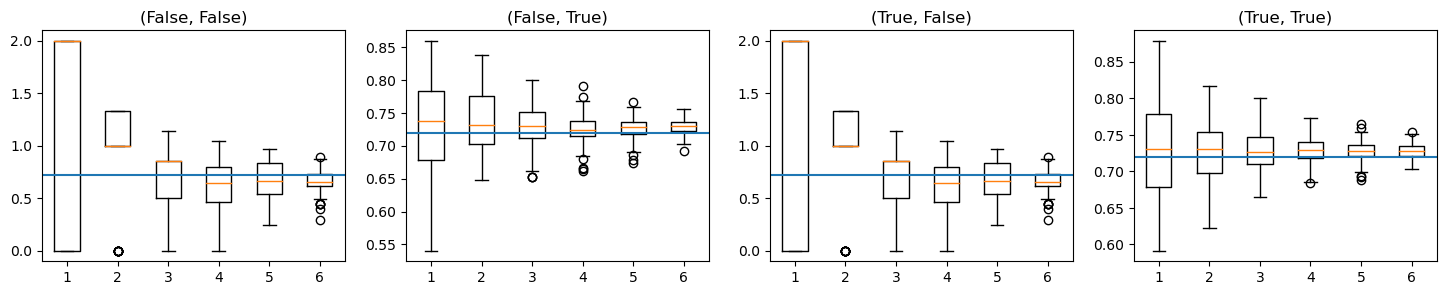

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(18, 3))
for (cfg, df_), ax in zip(df_cov_analysis.groupby(["repeated_trees", "repeated_instances"]), axs):
    ax.boxplot([vals for t, vals in df_.groupby("t")["cov"]])
    ax.set_title(f"{cfg}")
    ax.axhline(0.72)
plt.show()

# Is $Cov[\lambda_i^{ss'},\lambda_i^{ss''}]$ independent of the choice of $s$. $s'$, and $s''$?

In [26]:
rows = []

for t in [2**i for i in range(2, 6)]:
    print(t)
    covs_t = []
    for seed in tqdm(range(100)):
        base_config = {
            "t": t,
            "random_state_clf": seed
        }
        lambdas = get_lambdas(**base_config)

        lb_base = LambdaBuilder(lambdas)
        
        """
            COV[ss_p, ss_pp]
        """
        
        # for no repeated trees
        lb1 = lb_base.copy().unequals()
        lb2 = lb_base.copy().unequals()
        #display(lb1.lambdas)
        #display(lb2.lambdas)
        lb1.combine(lb2, lambda_filter=lambda df: (df["s1"] == df["s3"]) | (df["s1"] == df["s4"]) | (df["s2"] == df["s3"]) | (df["s2"] == df["s4"]))
        rows.append([t, False, True, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])
        lb1.unique(across_instances=True, one_per_instance=True)
        rows.append([t, False, False, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])
        
        # for repeated trees
        lb1 = lb_base.copy().unequals()
        lb2 = lb_base.copy().unequals()
        lb1.combine(lb2, lambda_filter=lambda df: (df["s1"] == df["s3"]) | (df["s1"] == df["s4"]) | (df["s2"] == df["s3"]) | (df["s2"] == df["s4"]))
        rows.append([t, True, True, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])
        lb1.unique(across_instances=True, one_per_instance=True)
        rows.append([t, True, False, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])

df_cov_analysis_1_shared_3_different = pd.DataFrame(rows, columns=["t", "repeated_trees", "repeated_instances", "seed", "cov"])
df_cov_analysis_1_shared_3_different

4


  0%|          | 0/100 [00:00<?, ?it/s]

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

8


/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

  0%|          | 0/100 [00:00<?, ?it/s]

16


  0%|          | 0/100 [00:00<?, ?it/s]

32


  0%|          | 0/100 [00:00<?, ?it/s]

,t,repeated_trees,repeated_instances,seed,cov
0,4,False,True,0,0.145564
1,4,False,False,0,NaN
2,4,True,True,0,0.145564
3,4,True,False,0,NaN
4,4,False,True,1,0.154386
...,...,...,...,...,...
1595,32,True,False,98,0.311111
1596,32,False,True,99,0.212542
1597,32,False,False,99,0.000000
1598,32,True,True,99,0.212542


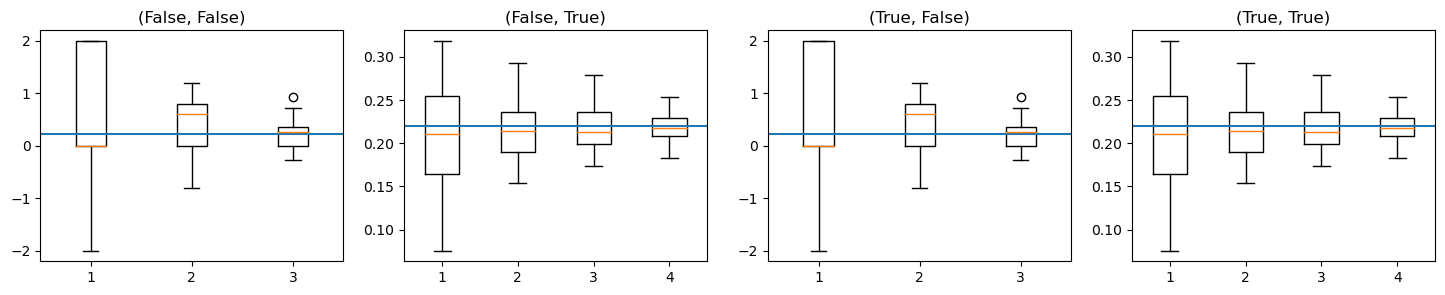

In [30]:
fig, axs = plt.subplots(1, 4, figsize=(18, 3))
for (cfg, df_), ax in zip(df_cov_analysis_1_shared_3_different.dropna().groupby(["repeated_trees", "repeated_instances"]), axs):
    ax.boxplot([vals for t, vals in df_.groupby("t")["cov"]])
    ax.set_title(f"{cfg}")
    ax.axhline(0.22)
plt.show()

# Is $Cov[\lambda_i^{ss'},\lambda_i^{s''s'''}]$ independent of the choice of $s$. $s'$, $s''$ and $s'''$?

## Case 1: 2 different, i.e., $s = s'$ and $s'' = s'''$

In [37]:
rows = []

for t in [2**i for i in range(2, 8)]:
    print(t)
    covs_t = []
    for seed in tqdm(range(100)):
        base_config = {
            "t": t,
            "random_state_clf": seed
        }
        lambdas = get_lambdas(**base_config)

        lb_base = LambdaBuilder(lambdas)
        
        """
            COV[ss_p, s_ps_ppp]
        """
        
        # for no repeated trees
        lb1 = lb_base.copy().equals()
        lb2 = lb_base.copy().equals()
        lb1.combine(lb2, lambda_filter=lambda df: (df["s1"] != df["s3"]) & (df["s1"] != df["s4"]) & (df["s2"] != df["s3"]) & (df["s2"] != df["s4"]))
        rows.append([t, False, True, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])
        lb1.unique(across_instances=True, one_per_instance=True)
        rows.append([t, False, False, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])
        
        # for repeated trees
        lb1 = lb_base.copy().equals()
        lb2 = lb_base.copy().equals()
        lb1.combine(lb2, lambda_filter=lambda df: (df["s1"] != df["s3"]) & (df["s1"] != df["s4"]) & (df["s2"] != df["s3"]) & (df["s2"] != df["s4"]))
        rows.append([t, True, True, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])
        lb1.unique(across_instances=True, one_per_instance=True)
        rows.append([t, True, False, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])

df_cov_analysis_0_shared_2_different = pd.DataFrame(rows, columns=["t", "repeated_trees", "repeated_instances", "seed", "cov"])
df_cov_analysis_0_shared_2_different

4


  0%|          | 0/100 [00:00<?, ?it/s]

8


  0%|          | 0/100 [00:00<?, ?it/s]

16


  0%|          | 0/100 [00:00<?, ?it/s]

32


  0%|          | 0/100 [00:00<?, ?it/s]

64


  0%|          | 0/100 [00:00<?, ?it/s]

128


  0%|          | 0/100 [00:00<?, ?it/s]

,t,repeated_trees,repeated_instances,seed,cov
0,4,False,True,0,0.172198
1,4,False,False,0,2.000000
2,4,True,True,0,0.172198
3,4,True,False,0,2.000000
4,4,False,True,1,0.164252
...,...,...,...,...,...
2395,128,True,False,98,0.149802
2396,128,False,True,99,0.214715
2397,128,False,False,99,0.115079
2398,128,True,True,99,0.214715


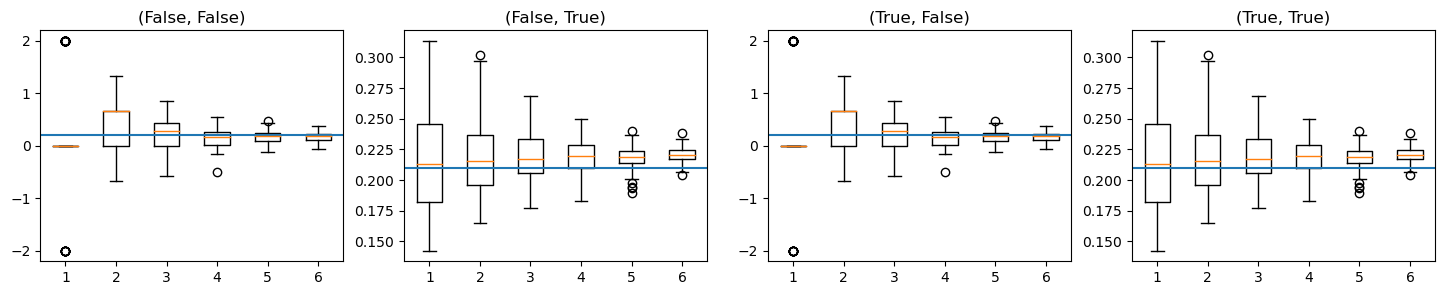

In [38]:
fig, axs = plt.subplots(1, 4, figsize=(18, 3))
for (cfg, df_), ax in zip(df_cov_analysis_0_shared_2_different.groupby(["repeated_trees", "repeated_instances"]), axs):
    ax.boxplot([vals for t, vals in df_.groupby("t")["cov"]])
    ax.set_title(f"{cfg}")
    ax.axhline(0.21)
plt.show()

## Case 2: 3 different, i.e., ($s = s'$ and $s'' \neq s'''$) or ($s \neq s'$ and $s'' = s'''$)

In [3]:
rows = []

for t in [2**i for i in range(2, 7)]:
    print(t)
    covs_t = []
    for seed in tqdm(range(100)):
        base_config = {
            "t": t,
            "random_state_clf": seed
        }
        lambdas = get_lambdas(**base_config)

        lb_base = LambdaBuilder(lambdas)
        
        """
            COV[ss_p, s_ps_ppp]
        """
        
        # for no repeated trees
        lb1 = lb_base.copy().unequals()
        lb2 = lb_base.copy().equals()
        lb1.combine(lb2, lambda_filter=lambda df: (df["s1"] != df["s3"]) & (df["s1"] != df["s4"]) & (df["s2"] != df["s3"]) & (df["s2"] != df["s4"]))
        rows.append([t, False, True, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])
        lb1.unique(across_instances=True, one_per_instance=True)
        rows.append([t, False, False, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])
        
        # for repeated trees
        lb1 = lb_base.copy().unequals()
        lb2 = lb_base.copy().equals()
        lb1.combine(lb2, lambda_filter=lambda df: (df["s1"] != df["s3"]) & (df["s1"] != df["s4"]) & (df["s2"] != df["s3"]) & (df["s2"] != df["s4"]))
        rows.append([t, True, True, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])
        lb1.unique(across_instances=True, one_per_instance=True)
        rows.append([t, True, False, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])

df_cov_analysis_0_shared_3_different = pd.DataFrame(rows, columns=["t", "repeated_trees", "repeated_instances", "seed", "cov"])
df_cov_analysis_0_shared_3_different

4


  0%|          | 0/100 [00:00<?, ?it/s]

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

8


/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

  0%|          | 0/100 [00:00<?, ?it/s]

16


  0%|          | 0/100 [00:00<?, ?it/s]

32


  0%|          | 0/100 [00:00<?, ?it/s]

64


  0%|          | 0/100 [00:00<?, ?it/s]

,t,repeated_trees,repeated_instances,seed,cov
0,4,False,True,0,0.221353
1,4,False,False,0,NaN
2,4,True,True,0,0.221353
3,4,True,False,0,NaN
4,4,False,True,1,0.142356
...,...,...,...,...,...
1995,64,True,False,98,-0.114286
1996,64,False,True,99,0.216223
1997,64,False,False,99,0.342857
1998,64,True,True,99,0.216223


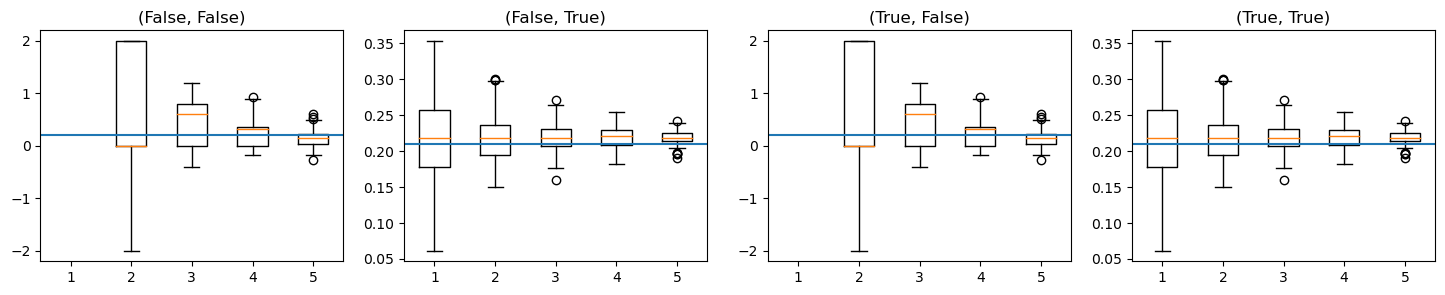

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(18, 3))
for (cfg, df_), ax in zip(df_cov_analysis_0_shared_3_different.groupby(["repeated_trees", "repeated_instances"]), axs):
    ax.boxplot([vals for t, vals in df_.groupby("t")["cov"]])
    ax.set_title(f"{cfg}")
    ax.axhline(0.21)
plt.show()

## Case 2: 3 different, i.e., ($s = s'$ and $s'' \neq s'''$) or ($s \neq s'$ and $s'' = s'''$)

In [ ]:
rows = []

for t in [2**i for i in range(2, 7)]:
    print(t)
    covs_t = []
    for seed in tqdm(range(100)):
        base_config = {
            "t": t,
            "random_state_clf": seed
        }
        lambdas = get_lambdas(**base_config)

        lb_base = LambdaBuilder(lambdas)
        
        """
            COV[ss_p, s_ps_ppp]
        """
        
        # for no repeated trees
        lb1 = lb_base.copy().unequals()
        lb2 = lb_base.copy().unequals()
        lb1.combine(lb2, lambda_filter=lambda df: (df["s1"] != df["s3"]) & (df["s1"] != df["s4"]) & (df["s2"] != df["s3"]) & (df["s2"] != df["s4"]))
        rows.append([t, False, True, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])
        lb1.unique(across_instances=True, one_per_instance=True)
        rows.append([t, False, False, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])
        
        # for repeated trees
        lb1 = lb_base.copy().unequals()
        lb2 = lb_base.copy().unequals()
        lb1.combine(lb2, lambda_filter=lambda df: (df["s1"] != df["s3"]) & (df["s1"] != df["s4"]) & (df["s2"] != df["s3"]) & (df["s2"] != df["s4"]))
        rows.append([t, True, True, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])
        lb1.unique(across_instances=True, one_per_instance=True)
        rows.append([t, True, False, seed, lb1.lambdas[["lambda1", "lambda2"]].cov().values[0, 1]])

df_cov_analysis_0_shared_4_different = pd.DataFrame(rows, columns=["t", "repeated_trees", "repeated_instances", "seed", "cov"])
df_cov_analysis_0_shared_4_different

4


  0%|          | 0/100 [00:00<?, ?it/s]

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

8


/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/felix/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1

  0%|          | 0/100 [00:00<?, ?it/s]

16


  0%|          | 0/100 [00:00<?, ?it/s]

32


  0%|          | 0/100 [00:00<?, ?it/s]

64


  0%|          | 0/100 [00:00<?, ?it/s]